Visualize the logorithm of the posterior of a shallow neural netwok on MNIST dataset by projecting each dimension at the MAP.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow.contrib.distributions import (
    NormalWithSoftplusScale, Categorical,
)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy

from nn4post import Inferencer
from nn4post.utils import get_param_shape, get_param_space_dim
from nn4post.utils.posterior import get_log_posterior
from nn4post.utils.tf_trainer import SimpleTrainer

from nn4post.utils import mnist

Reset TensorFlow:

In [2]:
tf.reset_default_graph()
tf.summary.FileWriterCache.clear()

Construct the `log_posterior` function:

In [3]:
# PARAMETERS
NOISE_STD = 0.0
BATCH_SIZE = 512


# DATA
mnist_ = mnist.MNIST(NOISE_STD, BATCH_SIZE)


# MODEL
n_inputs = 28 * 28  # number of input features.
n_hiddens = 15  # number of perceptrons in the (single) hidden layer.
n_outputs = 10  # number of perceptrons in the output layer.

with tf.name_scope('data'):
    x = tf.placeholder(shape=[None, n_inputs], dtype=tf.float32, name='x')
    y = tf.placeholder(shape=[None], dtype=tf.int32, name='y')

input_ = {'x': x}
observed = {'y': y}

def model(input_, param):
    """ Shall be implemented by TensorFlow. This is an example, as a shallow
    neural network.

    Args:
        input_:
            `dict`, like `{'x_1': x_1, 'x_2': x_2}, with values Tensors.
        param:
            `dict`, like `{'w': w, 'b': b}, with values Tensors.

    Returns:
        `dict`, like `{'y': Y}`, where `Y` is an instance of
        `tf.distributions.Distribution`.
    """
    # shape: `[None, n_hiddens]`
    hidden = tf.sigmoid(
        tf.matmul(input_['x'], param['w_h']) + param['b_h'])
    # shape: `[None, n_outputs]`
    logits = tf.matmul(hidden, param['w_a']) + param['b_a']

    Y = Categorical(logits=logits)
    return {'y': Y}


# PRIOR
with tf.name_scope('prior'):
    w_h = NormalWithSoftplusScale(
        loc=tf.zeros([n_inputs, n_hiddens]),
        scale=tf.ones([n_inputs, n_hiddens]) * 10,
        name="w_h")
    w_a = NormalWithSoftplusScale(
        loc=tf.zeros([n_hiddens, n_outputs]),
        scale=tf.ones([n_hiddens, n_outputs]) * 10,
        name="w_a")
    b_h = NormalWithSoftplusScale(
        loc=tf.zeros([n_hiddens]),
        scale=tf.ones([n_hiddens]) * 100,
        name="b_h")
    b_a = NormalWithSoftplusScale(
        loc=tf.zeros([n_outputs]),
        scale=tf.ones([n_outputs]) * 100,
        name="b_a")

param_prior = {
    'w_h': w_h, 'w_a': w_a,
    'b_h': b_h, 'b_a': b_a,
}

param_shape = get_param_shape(param_prior)
param_space_dim = get_param_space_dim(param_shape)
print('\n-- Dimension of parameter-space: {}.\n'.format(param_space_dim))

# POSTERIOR
scale = mnist_.n_data / mnist_.batch_size
log_posterior = get_log_posterior(
    model, input_, observed, param_prior, scale=scale)


-- Dimension of parameter-space: 11935.



Construct the loss with the variable of `log_posterior` a `tf.Variable`:

In [4]:
theta_var = tf.get_variable('theta', [param_space_dim])
loss = -1 * log_posterior(theta_var)

Thus find the MAP and save it to disk:

In [5]:
# TRAIN
batch_generator = mnist_.batch_generator()
def get_feed_dict_generator():
    while True:
        x_train, y_train, y_err_train = next(batch_generator)
        y_train = np.argmax(y_train, axis=1).astype('int32')
        yield {x: x_train, y: y_train}
feed_dict_generator = get_feed_dict_generator()

optimizer = tf.train.AdamOptimizer(0.001)
train_op = optimizer.minimize(loss)
tf.summary.scalar('loss', loss)
summary_op = tf.summary.merge_all()
writer = tf.summary.FileWriter('./dat/logdir/visualize')
init = tf.global_variables_initializer()
saver = tf.train.Saver()

sess_config = tf.ConfigProto()
sess_config.gpu_options.per_process_gpu_memory_fraction = 0.3
sess = tf.Session(config=sess_config)
sess.run(init)

for i in tqdm(range(400000)):
    feed_dict = next(feed_dict_generator)
    _, summary = sess.run([train_op, summary_op], feed_dict=feed_dict)
    if i % 100 == 0:
        writer.add_summary(summary, i)
saver.save(sess, './dat/checkpoints/visualize/checkpoint.ckpt')

100%|██████████| 400000/400000 [18:53<00:00, 352.78it/s]


'./dat/checkpoints/visualize/checkpoint.ckpt'

In [6]:
best_theta_val = sess.run(theta_var)

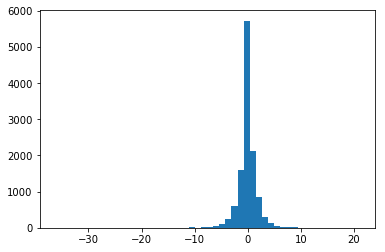

In [7]:
plt.hist(best_theta_val, bins=50)
plt.show()

Finally, make visualizations:

(Just for checking the correctness of the training, we also plot the best-fit point by a red vertical line.)

In [29]:
theta_ph = tf.placeholder(shape=best_theta_val.shape, dtype='float32')
log_post_with_ph = log_posterior(theta_ph)
x_val, y_val, *rests = mnist_.training_data
y_val = np.argmax(y_val, axis=1).astype('int32')

def visualize_log_post(axis, pixal):
    # Get thetas
    n = int(20 / pixal)
    theta_vals = np.zeros([n] + list(best_theta_val.shape))
    for i in range(n):
        theta_val = deepcopy(best_theta_val)
        theta_val[axis] = np.random.uniform(best_theta_val[axis] - 10,
                                            best_theta_val[axis] + 10)
        theta_vals[i] = theta_val
        
    # Get posteriors
    log_post_vals = []
    for theta_val in theta_vals:
        feed_dict = {
            x: x_val,
            y: y_val,
            theta_ph: theta_val,
        }
        log_post_val = sess.run(log_post_with_ph, feed_dict)
        log_post_vals.append(log_post_val)
    log_post_vals = np.array(log_post_vals, dtype='float32')
    
    # Plot
    sorted_indices = np.argsort(theta_vals[:,axis])
    plot_x = theta_vals[:,axis][sorted_indices]
    plot_y = log_post_vals[sorted_indices]
    plt.plot(plot_x, plot_y)
    plt.axvline(x=best_theta_val[axis], color='red', linestyle='--')
    plt.show()

In [30]:
len({_ for _ in best_theta_val if np.abs(_) > 0.5})

6507

Axis 3909:


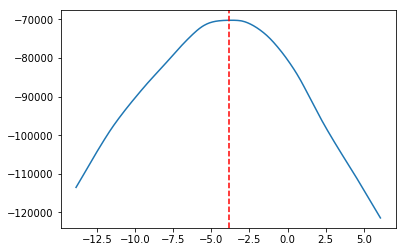

Axis 9482:


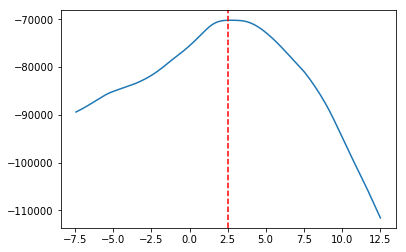

Axis 7268:


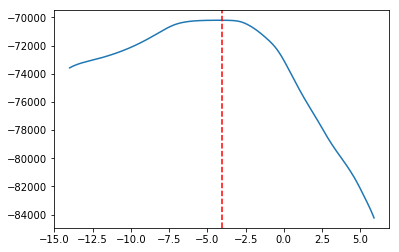

Axis 9041:


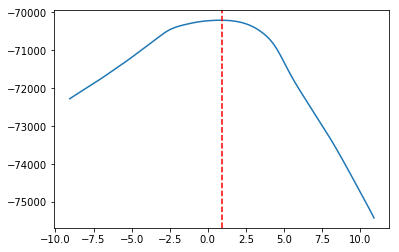

Axis 4531:


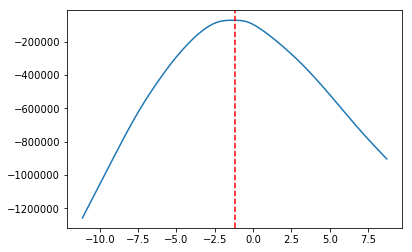

Axis 5980:


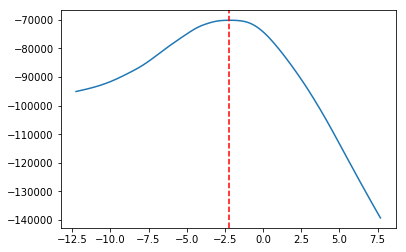

Axis 7155:


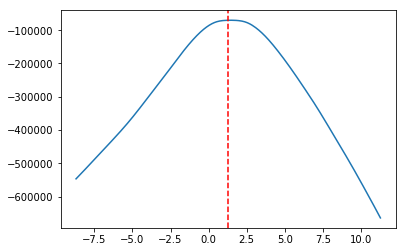

Axis 3697:


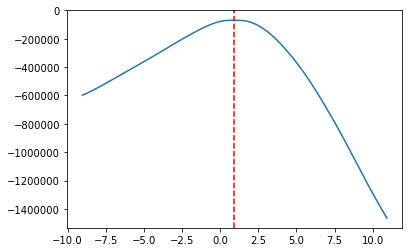

Axis 3503:


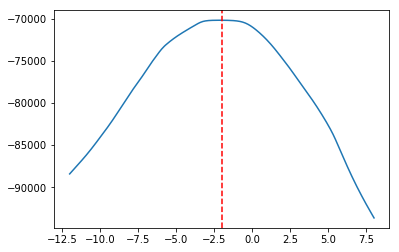

Axis 9082:


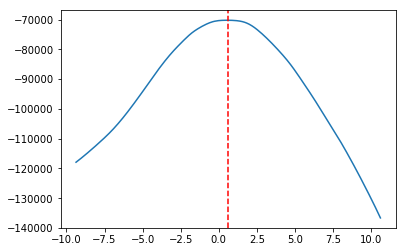

Axis 5048:


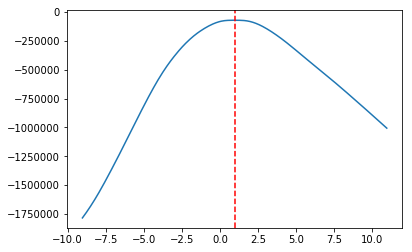

Axis 112:


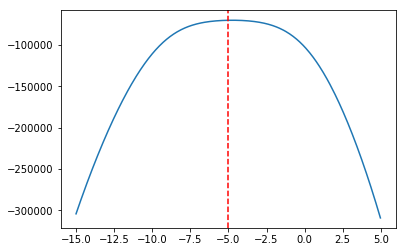

Axis 2943:


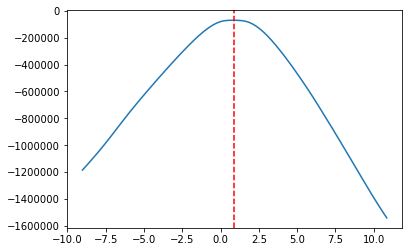

Axis 8679:


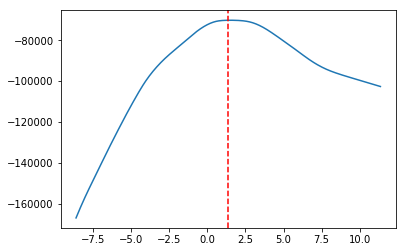

Axis 5797:


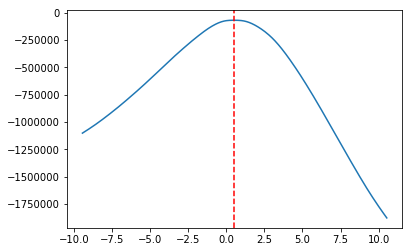

Axis 7705:


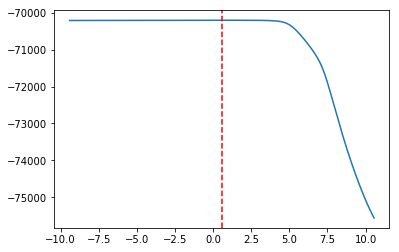

Axis 2388:


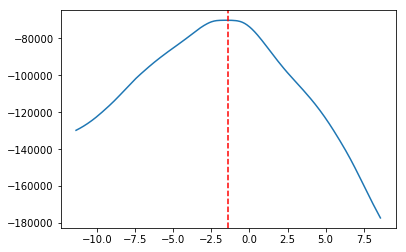

Axis 2094:


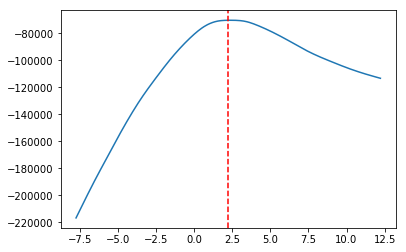

Axis 3034:


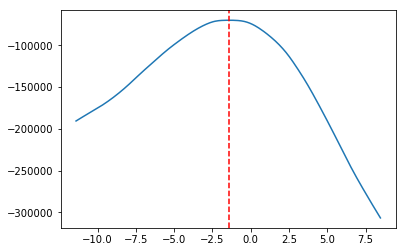

Axis 4964:


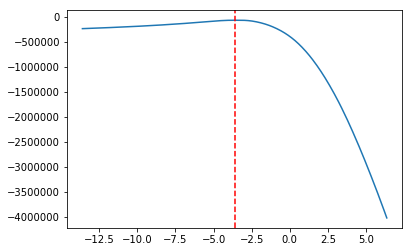

Axis 9744:


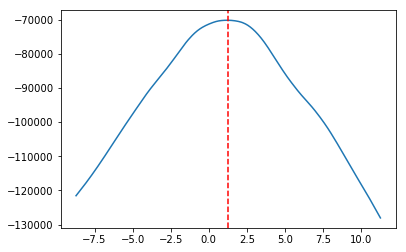

Axis 7173:


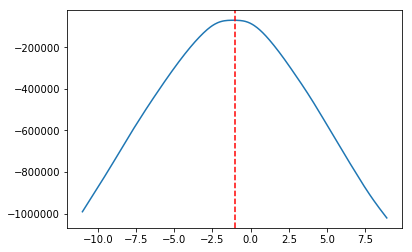

Axis 8287:


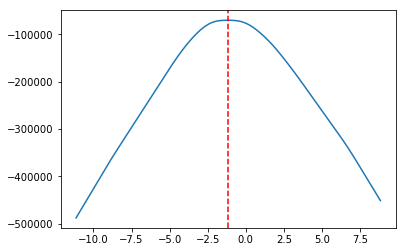

Axis 6662:


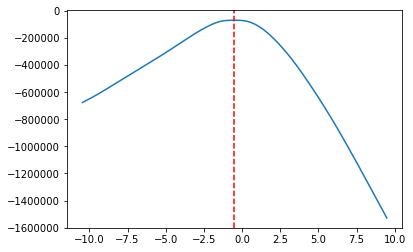

Axis 11041:


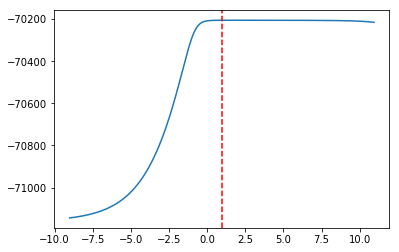

Axis 7500:


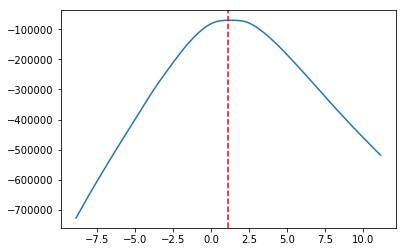

Axis 4517:


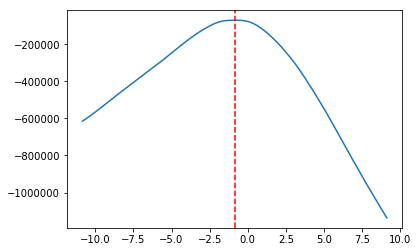

Axis 2961:


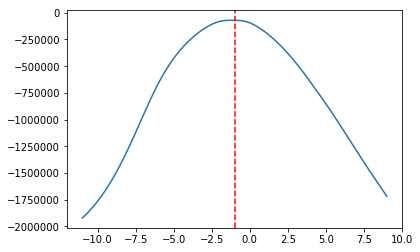

Axis 9263:


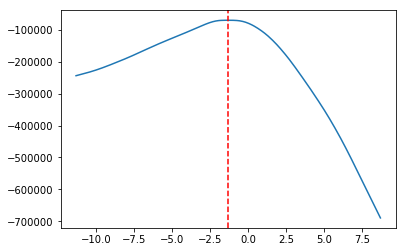

Axis 8962:


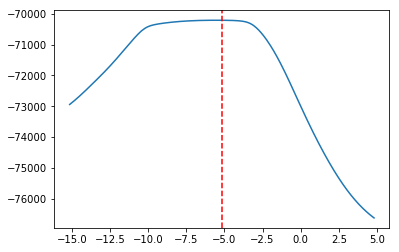

Axis 9736:


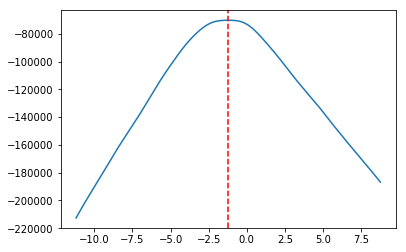

Axis 6804:


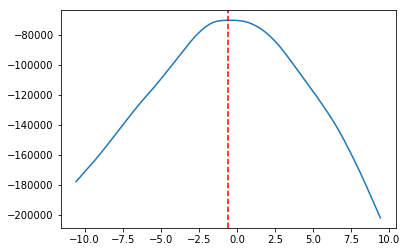

Axis 8044:


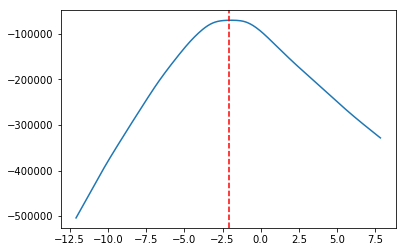

Axis 7595:


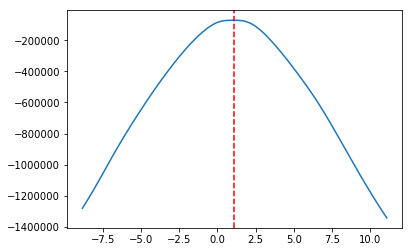

Axis 9999:


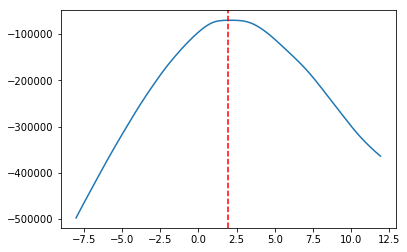

Axis 2469:


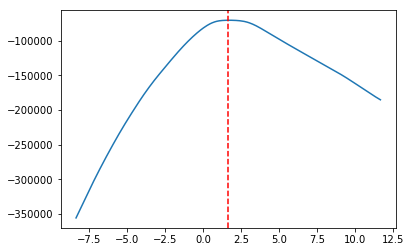

Axis 9095:


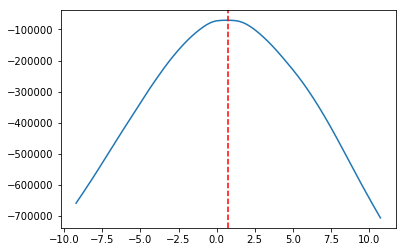

Axis 4015:


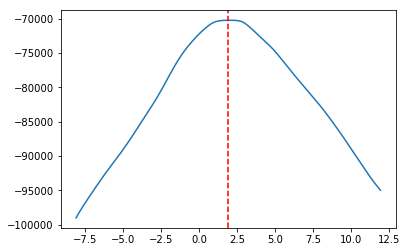

Axis 4092:


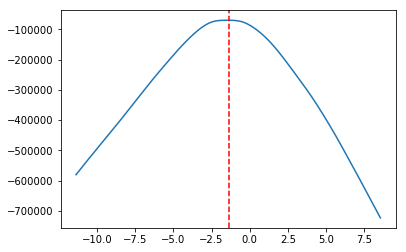

Axis 7075:


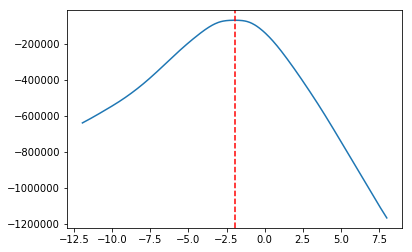

Axis 3163:


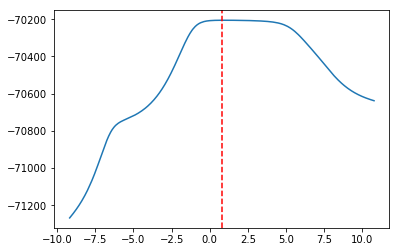

Axis 2452:


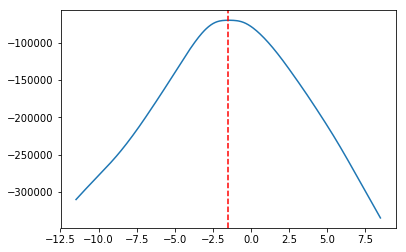

Axis 9498:


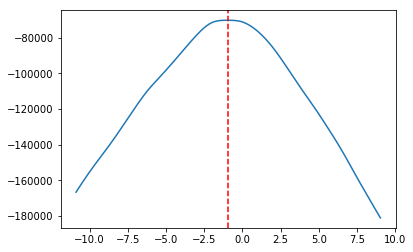

Axis 10374:


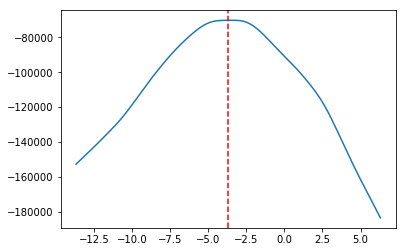

Axis 2616:


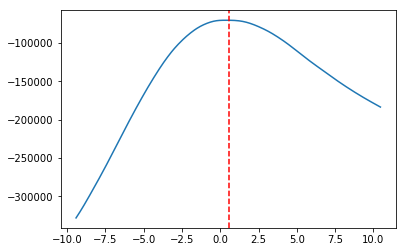

Axis 8916:


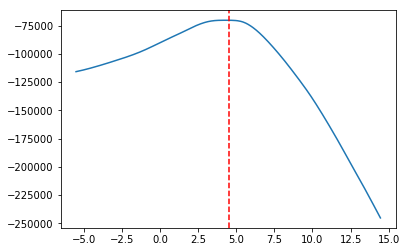

Axis 7610:


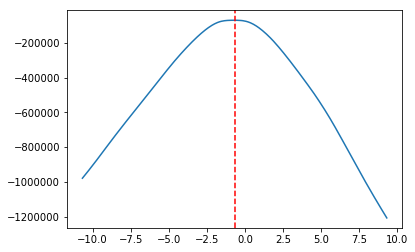

Axis 52:


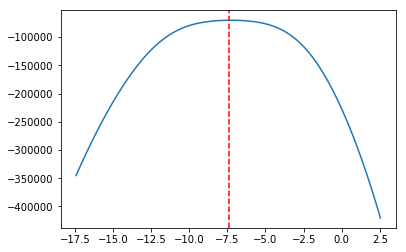

Axis 1554:


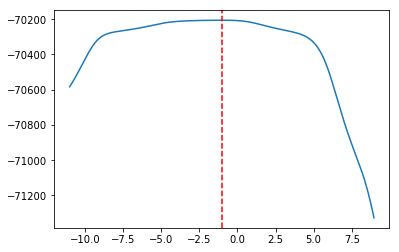

Axis 9383:


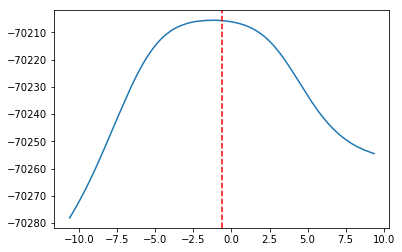

Axis 2064:


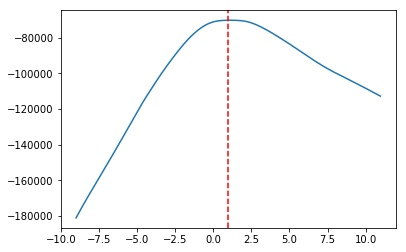

Axis 2020:


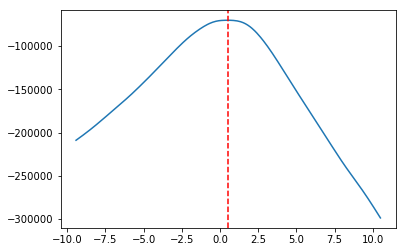

Axis 3076:


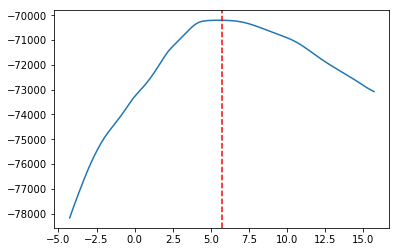

Axis 6106:


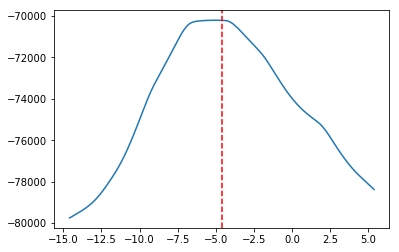

Axis 5337:


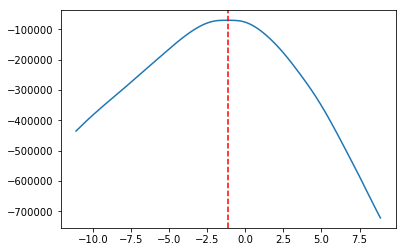

Axis 3229:


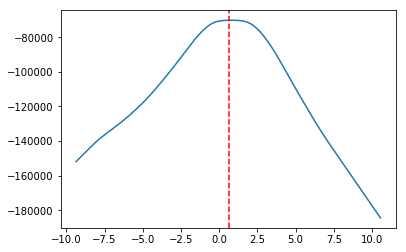

Axis 11306:


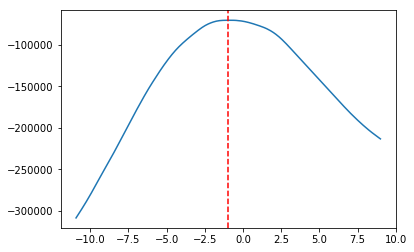

Axis 77:


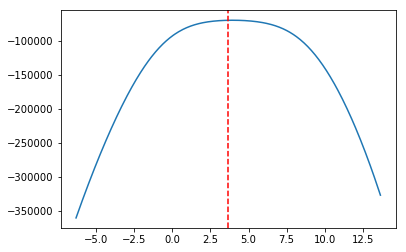

Axis 8085:


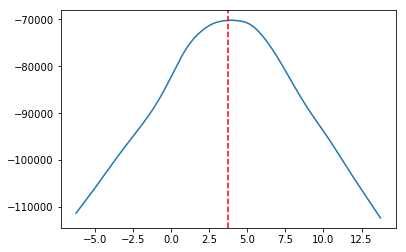

Axis 8638:


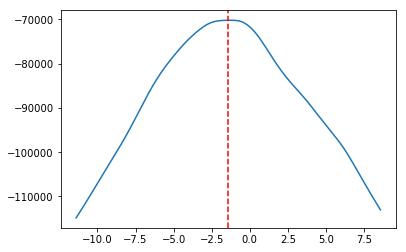

Axis 8541:


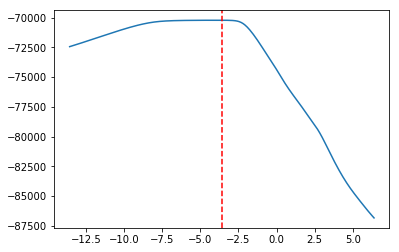

Axis 5184:


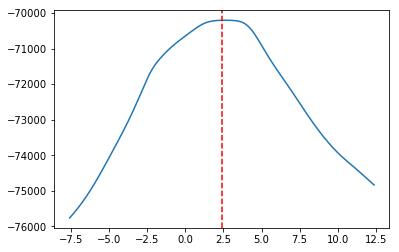

Axis 6335:


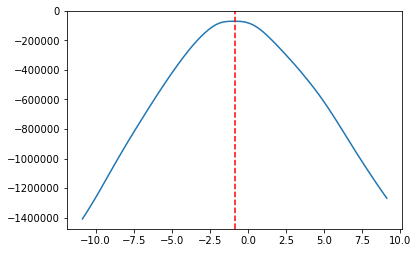

Axis 8291:


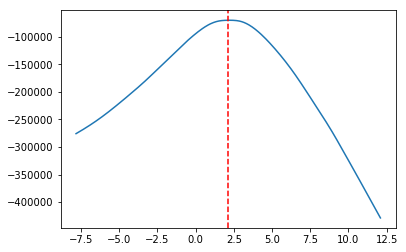

Axis 10130:


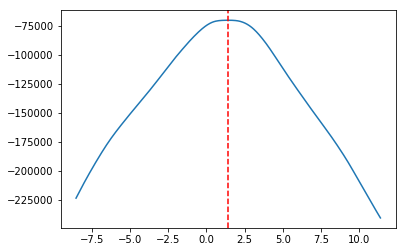

Axis 6027:


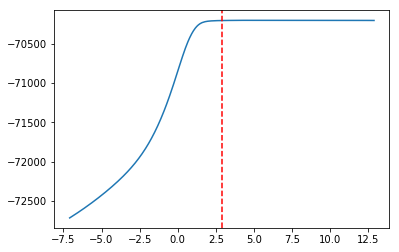

Axis 10204:


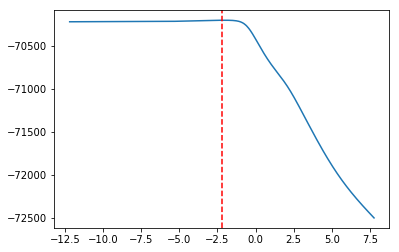

Axis 1775:


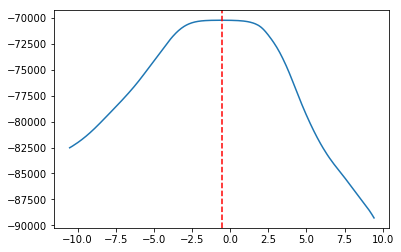

Axis 7605:


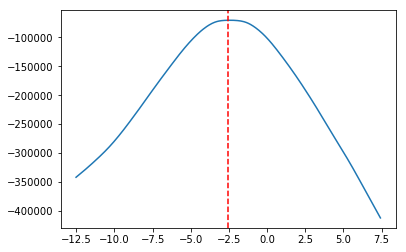

Axis 2432:


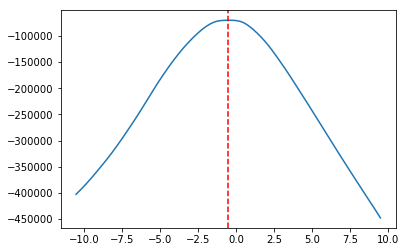

Axis 5974:


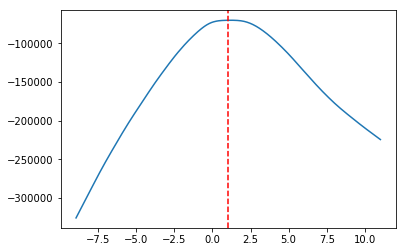

Axis 9169:


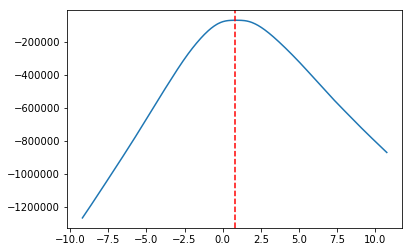

Axis 9623:


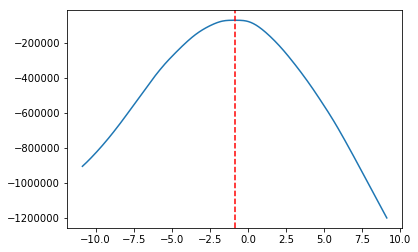

Axis 8803:


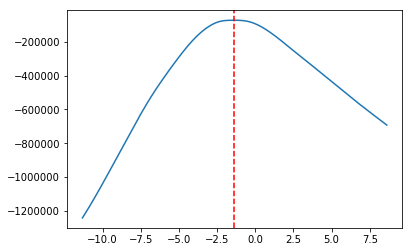

Axis 4221:


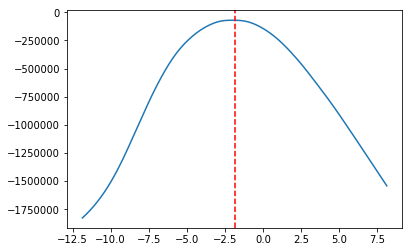

Axis 3570:


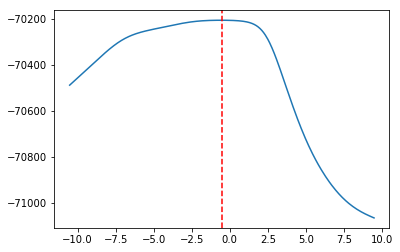

Axis 10793:


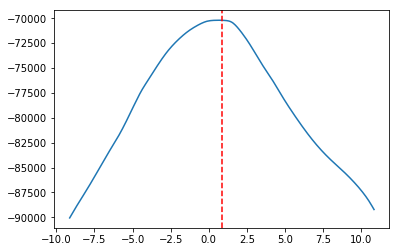

Axis 2608:


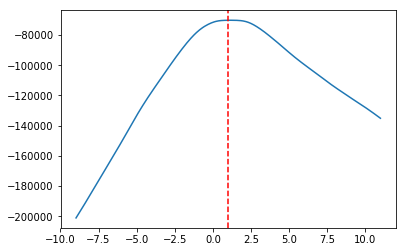

Axis 1749:


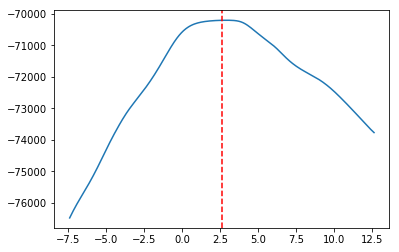

Axis 6569:


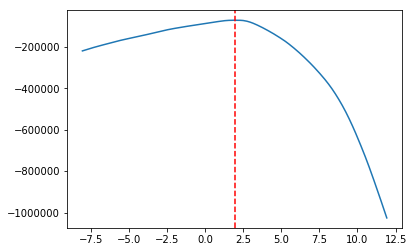

Axis 10593:


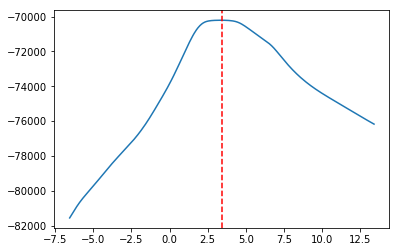

Axis 3614:


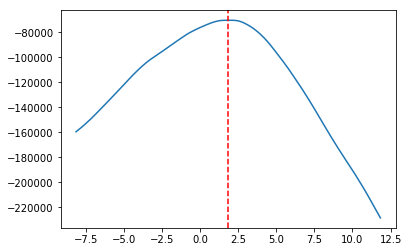

Axis 7357:


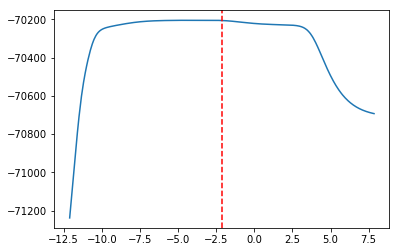

Axis 9950:


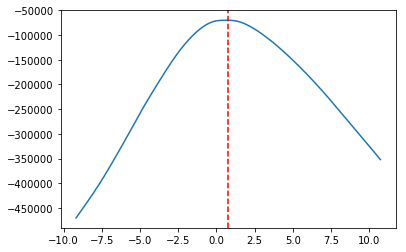

Axis 10912:


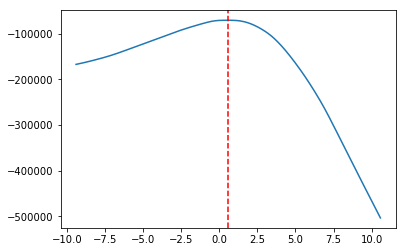

Axis 8478:


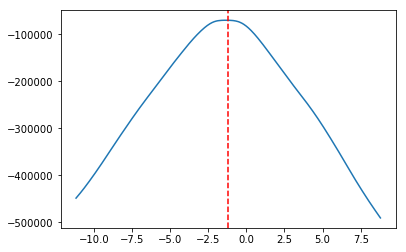

Axis 9072:


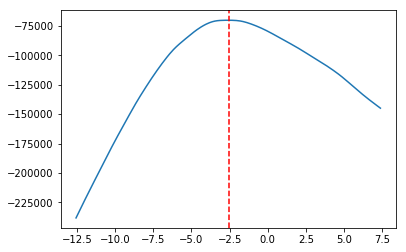

Axis 4017:


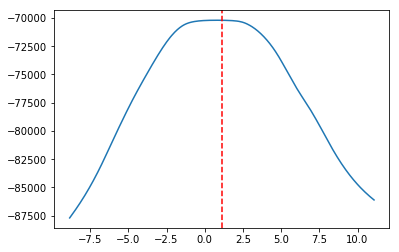

Axis 9932:


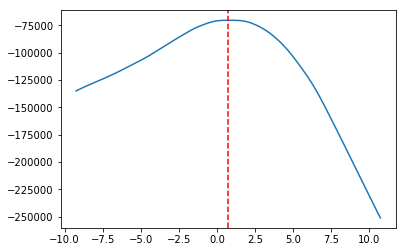

Axis 8040:


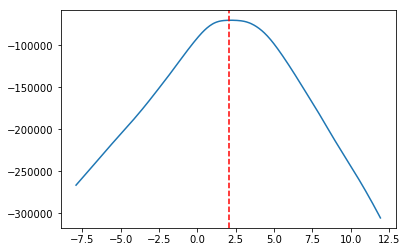

Axis 11197:


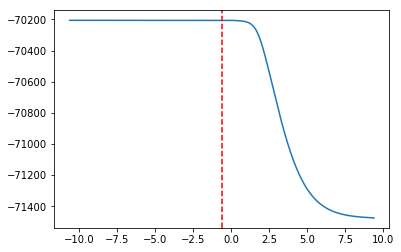

Axis 844:


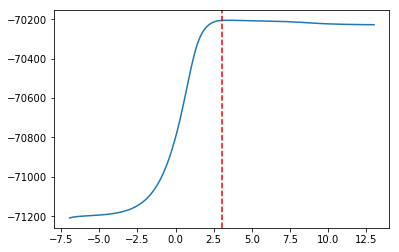

Axis 10390:


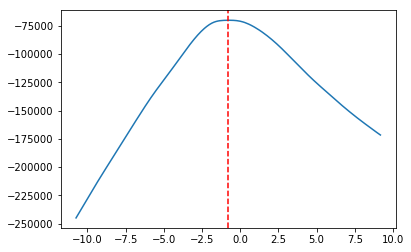

Axis 2906:


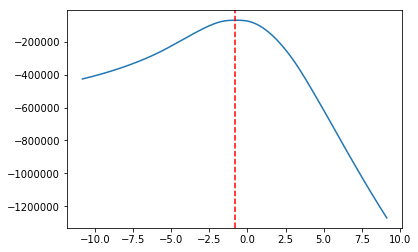

Axis 4492:


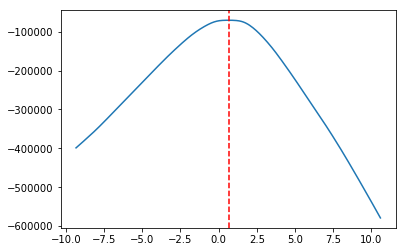

Axis 9545:


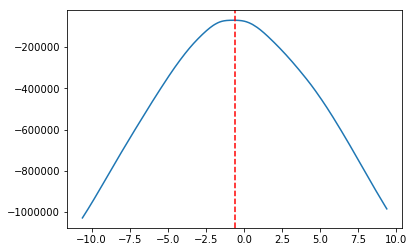

Axis 1259:


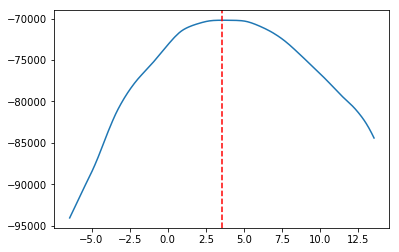

Axis 9923:


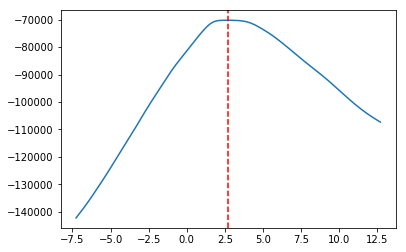

Axis 7124:


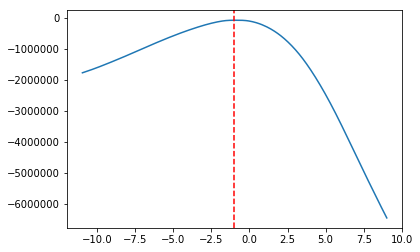

Axis 1966:


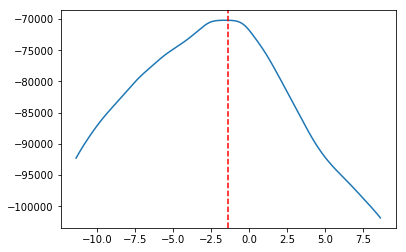

CPU times: user 46min 39s, sys: 37.7 s, total: 47min 17s
Wall time: 45min 4s


In [31]:
%%time

n_shows = 100
plotted_axes = set()
for _ in range(n_shows):
    while True:
        axis = np.random.randint(param_space_dim)
        if ( np.abs(best_theta_val[axis]) > 0.5
             and axis not in plotted_axes ):
            break
    print('Axis {}:'.format(axis))
    visualize_log_post(axis, pixal=0.02)
    plotted_axes.add(axis)